# Notebook for all simulations

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from check_warmup import avg_warmup_count, plot_avg_warmup_count

from environment import GLMBandit

from glmbanditexp.algorithms.ecolog import EcoLog
from glmbanditexp.algorithms.gloc import Gloc
from glmbanditexp.algorithms.glm_ucb import GlmUCB
from glmbanditexp.algorithms.rs_glinucb import RS_GLinUCB
from glmbanditexp.algorithms.ofulogplus import OFULogPlus

### Warm-up Count for Rarely-Switching GLBandit

In [2]:
num_trials = 5
d=5
K=10
T=200000
kappa=50.0
R=1.0
S=5.0
lmbda=20.0
seed=186329

Running trial 1


100%|██████████| 200000/200000 [00:03<00:00, 50556.53it/s]


Running trial 2


100%|██████████| 200000/200000 [00:03<00:00, 51674.58it/s]


Running trial 3


100%|██████████| 200000/200000 [00:03<00:00, 50734.25it/s]


Running trial 4


100%|██████████| 200000/200000 [00:03<00:00, 50428.67it/s]


Running trial 5


100%|██████████| 200000/200000 [00:03<00:00, 50088.35it/s]


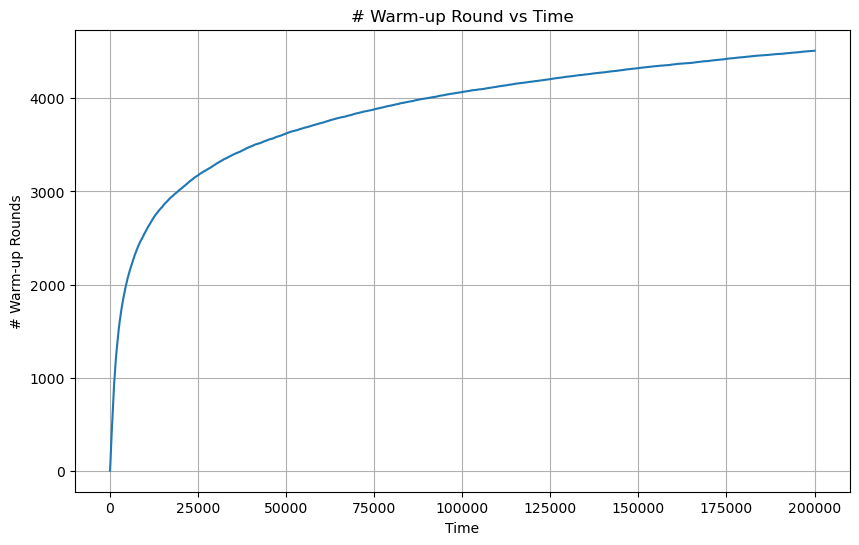

In [3]:
count = avg_warmup_count(num_trials, d, K, T, kappa, R, S, lmbda, seed)
plot_avg_warmup_count(count, show_flag=True)

## Regret Simulations

In [2]:
def simulate(num_trials, env, algo_names_list, delta):
    regret_dict = {}
    for n in range(num_trials):
        algo_arr = []
        print('Simulating trial', n+1)
        for k in algo_names_list:
            if k == 'RS-GLinUCB':
                algo = RS_GLinUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
            elif k == 'GLOC':
                algo = Gloc(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
            elif k == 'GLM-UCB':
                algo = GlmUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
            elif k == 'EcoLog':
                algo = EcoLog(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
            elif k == 'OfuLog+':
                algo = OFULogPlus(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
            algo_arr.append(algo)
    
        for t in tqdm(range(env.T)):
            act_arr = []
            for algo in algo_arr:
                act_arr.append(algo.play_arm())
            try:
                rewards, regrets, next_arm_set = env.step(act_arr)
            except:
                print(act_arr)


            for j, algo in enumerate(algo_arr):                
                algo.update(rewards[j], regrets[j], next_arm_set)
        
        for algo in algo_arr:
            if algo.name not in regret_dict.keys():
                regret_dict[algo.name] = np.array(algo.regret_arr)
            else:
                regret_dict[algo.name] += np.array(algo.regret_arr)
        env.reset()
    
    for k in regret_dict.keys():
        regret_dict[k] /= num_trials
    
    return regret_dict


In [3]:
def plot_regret(rg_dict, T):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    T_arr = np.arange(1, T+1)
    for k in rg_dict.keys():
        ax.plot(T_arr, np.cumsum(rg_dict[k]), label=k)
    ax.legend()
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Regret')
    ax.set_title('Regret vs Time')
    plt.show()

### Logistic Model Simulation

In [10]:
config = {"full_norm": True}
config['seed'] = 109832
config['model'] = 'Logistic'
config['theta_dim'] = 5
config['num_arms'] = 10
config['theta_norm'] = 5.0
config['horizon_length'] = 20000

env = GLMBandit(config=config)
print('Kappa =', env.kappa)
print('Theta =' , env.theta)

Calculating kappa...


100%|██████████| 20000/20000 [00:00<00:00, 108264.41it/s]


Kappa = 141.6361569007383
Theta = [ 0.48016631  2.96892264  1.23390047  0.41655583 -3.77609713]


Simulating trial 1


100%|██████████| 20000/20000 [00:35<00:00, 565.32it/s]


Simulating trial 2


100%|██████████| 20000/20000 [00:35<00:00, 571.12it/s]


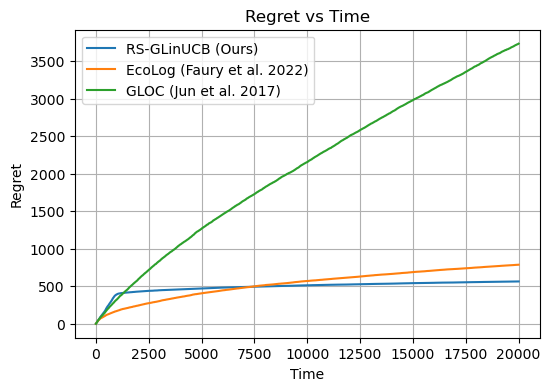

In [11]:
algo_names_list = ['RS-GLinUCB', 'EcoLog', 'GLOC']
num_trials = 2

regret_dict = simulate(num_trials, env, algo_names_list, 0.01)
plot_regret(regret_dict, env.T)

### Probit Model Simulation

In [7]:
config = {}
config['seed'] = 109832
config['model'] = 'Probit'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 3.0
config['horizon_length'] = 2000
config['full_norm'] = True

env = GLMBandit(config=config)
print('Kappa =', env.kappa)

Calculating kappa...


100%|██████████| 2000/2000 [00:00<00:00, 12765.10it/s]


Kappa = 190.7941775004815


Simulating trial 1


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [03:06<00:00, 10.75it/s]


Simulating trial 2


100%|██████████| 2000/2000 [02:51<00:00, 11.69it/s]


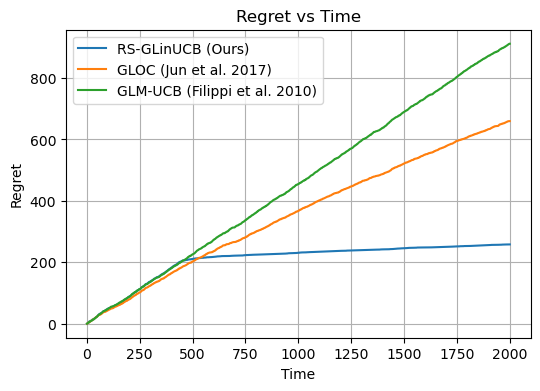

In [8]:
algo_names_list = ['RS-GLinUCB', 'GLOC', 'GLM-UCB']
num_trials = 2

regret_dict = simulate(num_trials, env, algo_names_list, 0.01)
plot_regret(regret_dict, env.T)

## Time Comparison

In [2]:
import time

In [6]:
def single_algo_multiple_runs(env, algo_name, num_trials):
    delta = 0.01
    dur_arr = []
    for _ in range(num_trials):
        if algo_name == 'RS-GLinUCB':
            algo = RS_GLinUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
        elif algo_name == 'GLOC':
            algo = Gloc(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
        elif algo_name == 'GLM-UCB':
            algo = GlmUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
        elif algo_name == 'EcoLog':
            algo = EcoLog(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
        elif algo_name == 'OfuLog+':
            algo = OFULogPlus(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
        
        start = time.monotonic_ns()
        for _ in range(env.T):
            a = algo.play_arm()
            r, reg, arms = env.step([a])
            algo.update(r[0], reg[0], arms)
        end = time.monotonic_ns()
        env.reset()
        dur_arr.append((end - start) / 1000000000.0)
    
    avg_dur = np.mean(dur_arr)
    std_dur = np.std(dur_arr)
    return algo.name, avg_dur, std_dur

In [9]:
algo_names = ['EcoLog', 'RS-GLinUCB']
config = {}
config['seed'] = 109832
config['model'] = 'Logistic'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 2.0
config['horizon_length'] = 5000
config['full_norm'] = True

env = GLMBandit(config=config)
print('Kappa =', env.kappa)

Calculating kappa...


100%|██████████| 5000/5000 [00:00<00:00, 11801.99it/s]


Kappa = 9.276376863373896


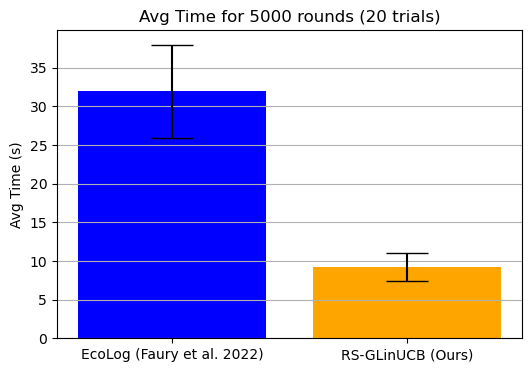

In [10]:
num_trials = 20
algo_dict = {}
for k in algo_names:
    name, avg_time, std_time = single_algo_multiple_runs(env, k, num_trials)
    algo_dict[name] = (avg_time, std_time)

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(list(algo_dict.keys()), [algo_dict[k][0] for k in algo_dict.keys()], yerr=[algo_dict[k][1] for k in algo_dict.keys()], color = ['blue', 'orange'], ecolor='black', capsize=15)
ax.set_ylabel('Avg Time (s)')
ax.grid(axis='y')
ax.set_title(f'Avg Time for {env.T} rounds ({num_trials} trials)')
plt.show()